In [1]:
#Add libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Load data processed on the HPC

prs = pd.read_csv("../data/protein_prs_cases.csv", sep="\t", index_col=0)

prs.head()

,Group,Case,Sex,C4A.C4B.4481.34.2,IL10.2773.50.2,MMP9.2579.17.5,CSF3.8952.65.3,GC.6581.50.3,APOB.2797.56.2,CFH.4159.130.1,...,C3.2755.8.2,PPY.4588.1.2,IGFBP2.2570.72.5,APOE.2937.10.2,FGA.FGB.FGG.4907.56.1,PLG.3710.49.2,TNF.5936.53.3,ANGPT2.13660.76.3,CRP.4337.49.2,VCAM1.2967.8.1
0,A,2,2,-0.069435,-0.034924,-0.126787,0.351996,0.314848,-0.318171,0.195647,...,0.057947,0.749855,0.146249,-0.133883,-2.490502,-0.324963,-0.978661,0.039893,-0.266216,-0.038887
1,A,2,2,-1.071661,-0.421213,-0.872182,0.101832,-0.296282,0.689710,-0.409555,...,-0.903393,0.306309,-1.152134,0.421410,0.405951,0.950770,1.549364,1.410669,-1.659654,2.214628
2,A,2,1,0.321382,-2.000421,-0.126787,0.207792,0.952631,-2.252077,-1.264962,...,1.754089,1.248028,1.187176,-1.003851,-0.848056,-0.324963,-1.076009,0.381713,-0.420168,-0.413070
3,A,2,2,0.575056,-0.256073,0.618608,-1.863235,-0.379302,0.689710,-0.636036,...,-1.259195,-0.329593,-0.662532,-0.133883,1.754016,0.614542,-1.708552,-1.134225,-1.053209,-0.110263
4,A,2,2,1.512781,0.417969,-0.126787,0.091216,-0.337681,-0.318171,-0.115083,...,0.554612,-0.582945,0.512406,0.843965,0.379672,-1.239034,0.858960,-0.683777,-0.344878,-0.487496


In [3]:
#Update case and sex from 2/1 and to dummy variables 1/0
#Case -> 1 = "AD", 0 = "CTL"
#Sex -> 1 = "Female", 0 = "Male"

if (prs["Case"].max() == 2) | (prs["Sex"].max() == 2):
    prs.loc[prs["Case"] == 1, "Case"] = 0
    prs.loc[prs["Case"] == 2, "Case"] = 1

    prs.loc[prs["Sex"] == 1, "Sex"] = 0
    prs.loc[prs["Sex"] == 2, "Sex"] = 1
else:
    print("Already updated")

print(prs[["Case", "Sex"]].describe())

print(prs.groupby("Group")["Case"].sum())

              Case          Sex
count  6244.000000  6244.000000
mean      0.686579     0.598334
std       0.463921     0.490274
min       0.000000     0.000000
25%       0.000000     0.000000
50%       1.000000     1.000000
75%       1.000000     1.000000
max       1.000000     1.000000
Group
A    3277
B     639
C     371
Name: Case, dtype: int64


In [9]:
#METHOD TO PREPARE RESULTS (ADJUST FOR SVM INPUTS)
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

def assess_model_performance(md, pred, X_test, y_test, kernel, plot=True):
    accuracy_sk = md.score(X_test, y_test)
    auc = roc_auc_score(y_test, md.predict(X_test))
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    sensitivity = tp / (tp + fn) #-> also recall
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    
    result = pd.DataFrame({"kernel":kernel, 
                           "accuracy":accuracy_sk, 
                           "sensitivity": sensitivity, 
                           "specificity":specificity,
                           "precision":precision,
                           "auc":auc}, index=[1])
    
    if plot:
        probas = md.predict_proba(X_test)
        plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1], label=kernel)
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend(prop={'size':10}, loc='lower right')
    
    return result

    kernel  accuracy  sensitivity  specificity  precision       auc
0     poly  0.672646     0.922430     0.128310   0.697527  0.525370
1      rbf  0.690583     0.972897     0.075356   0.696321  0.524127
3  sigmoid  0.685458     0.966355     0.073320   0.694426  0.519837
2   linear  0.685458     1.000000     0.000000   0.685458  0.500000


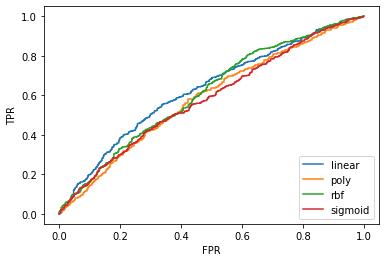

In [12]:
#SVM Classifier tested with combination of hyperparameters (TBD)

    
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

PROTEIN_DATA = prs.iloc[:, 3:]
RESULTS = pd.DataFrame()

#Split data into training and hold-out test
x_train, x_test, y_train, y_test = train_test_split(PROTEIN_DATA, prs["Case"], test_size=0.25, random_state=0)

#Explore use of different kernels (excluded pre-computed as error implies have to provide own kernel as input or that matrix must be a square matrix)
kernels = ["linear", "poly", "rbf", "sigmoid"]

for kernel in kernels:
    #Probability=True using a 5-fold cross validation method and may differ from results using 'predict' method.
    #Consider alternative for plotting ROC curve
    clf = SVC(kernel=kernel, probability=True)
    md = clf.fit(x_train, y_train)

    pred = md.predict(x_test)

    #Explore how assess importance of different variables
    result = assess_model_performance(md, pred, x_test, y_test, kernel)

    RESULTS = RESULTS.append(result, ignore_index = True)

    RESULTS.sort_values(by="auc", ascending=False, inplace=True)

print(RESULTS)

#Findings
    #None of the SVM models appear to deliver better performance as measured by AUC. 
    #Constraint again appears to be inability to distinguish negative cases (e.g. low specificity).

In [ ]:
#Further reading at:
    #https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/
    #https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
    #https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
    #https://towardsdatascience.com/support-vector-machine-python-example-d67d9b63f1c8